In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs

import singletask_dep as st
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
encoding_type = 'relative'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False,deps=True)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [15]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [16]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about_adam2'

In [17]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5 

Using scikit learn accuracy por género en el conjunto about
MALE 0.9453125
FEMALE 0.0725 

GLOBAL: 0.5252525252525253 

Using scikit learn accuracy por género en el conjunto to
MALE 0.9610705596107056
FEMALE 0.05511811023622047 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 0.9393939393939394
FEMALE 0.0646900269541779 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6240636654431811 	 Validation loss: 0.5662035310672502 	 
  1%|          | 574/57400 [00:09<14:19, 66.09it/s]
Epoch 2 	 Training loss: 0.5092611909431863 	 Validation loss: 0.4995294157731331 	 
  2%|▏         | 1148/57400 [00:18<13:04, 71.66it/s]
Epoch 3 	 Training loss: 0.43954457462041635 	 Validation loss: 0.4603053578885935 	 
  3%|▎         | 1722/57400 [00:26<12:56, 71.70it/s]
Epoch 4 	 Training loss: 0.3962629742219473 	 Validation loss: 0.4383487928721864 	 
  4%|▍         | 2296/57400 [00:35<14:19, 64.14it/s]
Epoch 5 	 Training loss: 0.36064739216391634 	 Validation loss: 0.4226073622703552 	 
  5%|▌         | 2870/57400 [00:44<13:04, 69.51it/s]
Epoch 6 	 Training loss: 0.3336572247047873 	 Validation loss: 0.41636922702950946 	 
  6%|▌         | 3444/57400 [00:53<13:40, 65.75it/s]
Epoch 7 	 Training loss: 0.3105725690930147 	 Validation loss: 0.4288485504813113 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [01:02<13:29, 65.98it/s]
Epo

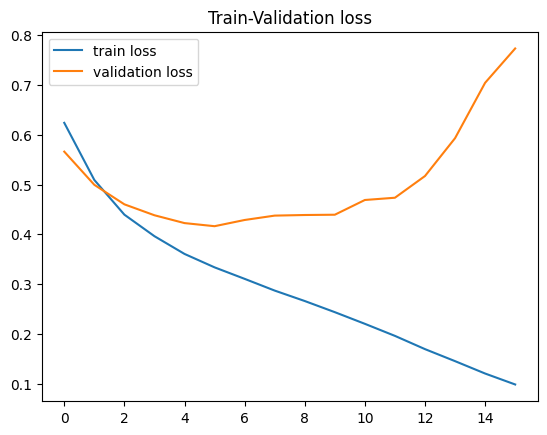

In [18]:
learning_rate = 0.001
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [19]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.7487244897959183 

Using scikit learn accuracy por género en el conjunto about
MALE 0.7578125
FEMALE 0.74 

GLOBAL: 0.6502525252525253 

Using scikit learn accuracy por género en el conjunto to
MALE 0.6253041362530414
FEMALE 0.6771653543307087 

GLOBAL: 0.6297262059973925 

Using scikit learn accuracy por género en el conjunto as
MALE 0.5959595959595959
FEMALE 0.6657681940700808 



# TO

In [20]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [21]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to_adam2'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937770454102692 	 Validation loss: 0.6925030300172709 	 
  1%|          | 574/57400 [00:09<15:12, 62.28it/s]
Epoch 2 	 Training loss: 0.6932923003563898 	 Validation loss: 0.6923541123584166 	 
  2%|▏         | 1148/57400 [00:18<13:39, 68.64it/s]
Epoch 3 	 Training loss: 0.6932663953885799 	 Validation loss: 0.6948856014316365 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:27<14:07, 65.66it/s]
Epoch 4 	 Training loss: 0.6930657654273801 	 Validation loss: 0.693768933667975 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:37<14:33, 63.05it/s]
Epoch 5 	 Training loss: 0.692807674407959 	 Validation loss: 0.6936612412080927 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:46<13:59, 64.95it/s]
Epoch 6 	 Training loss: 0.6925084966815722 	 Validation loss: 0.694187403735468 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:56<14:02, 64.02it/s]
Epoch 7 	 Training loss: 0.692292914469483 	 Validation loss

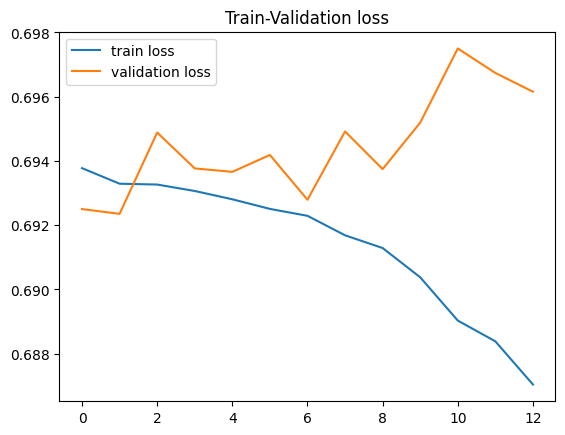

In [22]:
learning_rate = 0.001
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [23]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5063775510204082 

Using scikit learn accuracy por género en el conjunto about
MALE 0.036458333333333336
FEMALE 0.9575 

GLOBAL: 0.476010101010101 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0267639902676399
FEMALE 0.9606299212598425 

GLOBAL: 0.4810951760104302 

Using scikit learn accuracy por género en el conjunto as
MALE 0.03535353535353535
FEMALE 0.9568733153638814 



# AS

In [24]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as_adam2'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6938842880808933 	 Validation loss: 0.6935328517929983 	 
  1%|          | 574/57400 [00:10<15:33, 60.87it/s]
Epoch 2 	 Training loss: 0.693089187249074 	 Validation loss: 0.6939104502483949 	 
  2%|▏         | 1148/57400 [00:20<14:32, 64.45it/s]
Epoch 3 	 Training loss: 0.692360914438859 	 Validation loss: 0.6928512443930416 	 
  3%|▎         | 1722/57400 [00:29<15:17, 60.67it/s]
Epoch 4 	 Training loss: 0.6905464847744134 	 Validation loss: 0.6922487828691127 	 
  4%|▍         | 2296/57400 [00:39<15:19, 59.90it/s]
Epoch 5 	 Training loss: 0.6873313423233165 	 Validation loss: 0.6965653744794554 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:15, 63.73it/s]
Epoch 6 	 Training loss: 0.6833286997748584 	 Validation loss: 0.697085416923135 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:59<15:19, 58.69it/s]
Epoch 7 	 Training loss: 0.6793509783022079 	 Validation loss: 0.6915137424307355 	 
  7%|▋         | 4018/57400 [01:0

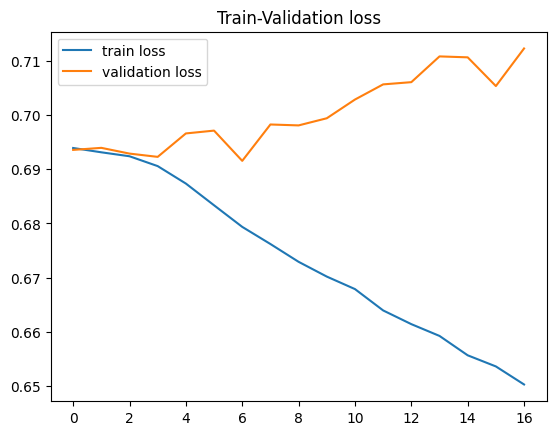

In [25]:
learning_rate = 0.001
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [26]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.48086734693877553 

Using scikit learn accuracy por género en el conjunto about
MALE 0.3567708333333333
FEMALE 0.6 

GLOBAL: 0.5151515151515151 

Using scikit learn accuracy por género en el conjunto to
MALE 0.43552311435523117
FEMALE 0.6010498687664042 

GLOBAL: 0.5814863102998696 

Using scikit learn accuracy por género en el conjunto as
MALE 0.48737373737373735
FEMALE 0.6819407008086253 

